In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from extraction_sm import *

# Data Acquisition

In [40]:
# let's process multiple files at once - I want some nicer statistic
# this is a time-ordered file of filenames for SM1 or SM2

fov = 1
pathfile = "../filenames_sm{}.txt".format(fov)


allfiles = []
f = open(pathfile, 'r')
allfiles = f.readlines()
f.close()

# strip away newlines and add absolute path prefix
allfiles = ["../../"+s.strip() for s in allfiles]


# select a few files - say some random date(s)
mydates = ["2017-06-30","2017-07-01","2017-07-02","2017-07-03","2017-07-04"]
#mydates = ["2017-06-30"]
#mydates = ["2017-09-11"]

sourcefiles = []

for date in mydates:
    sourcefiles += [s for s in allfiles if date in s]

#sourcefiles = [sourcefiles[]]  # if I want to use only one file


print("Using", len(sourcefiles), "files")

Using 21 files


In [41]:
out = []  # where our output will go
gains = []
rows = []
iobs = 0

# let's test the execution time
import time
timingstart = time.time()


for sourcefile in sourcefiles:
    print(iobs)
    iobs += 1
    (image,gain,bias,readnoise,fov,row,tstart,tstop) = sm_get_image(sourcefile, "../../datasets/sm_bias/sm_calibdat.fits")
    
    starmask = sm_starmask(image, 2000)

    output = sm_cosmics(image, gain, bias, readnoise, starmask, sigclip=10., sigfrac=0.3, objlim=10.)
    output.acqTime = tstart
    output.row = row
    output.fov = fov
    
    out.append(output)


timingend = time.time()
print("Elapsed time:", timingend - timingstart)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Elapsed time: 71.24307441711426


# Saving the data

In [20]:
# time it
import time
tstart = time.time()


outfile = 'output_test_flare.fits'
write_Obslist(out, outfile)


tend = time.time()
print("Elapsed time:", tend - tstart)

Elapsed time: 63.78663682937622


# Reading Data

In [17]:
import time
tstart = time.time()

inlist = read_Obslist_fits('output_test_flare.fits')

tend = time.time()
print("Elapsed time:", tend - tstart)

Elapsed time: 0.2928957939147949


# Some diagnostics

In [42]:
# Do some statistics

Etot = []

# also for lengths, why not
AL = []
AC = []

        
for ii in range(len(out)):
    Etot += list(out[ii].data["TRACK_EN"])
    AL += list(out[ii].data["DIM_AL"]-1)
    AC += list(out[ii].data["DIM_AC"]-1)


Etot = np.array(Etot)
AL = np.array(AL)
AC = np.array(AC)


        
# number of cosmics
print(len(Etot), "cosmics")


7017 cosmics


Energies

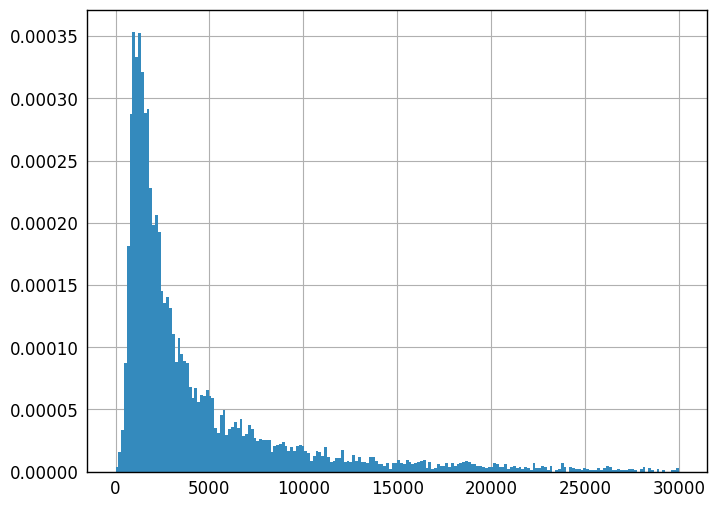

In [43]:
histE = plt.hist(Etot, 200, log=False ,range=(0,30000), normed=True)

Lengths and angles

In [44]:
# Let's try the angles
# For now without how it faces

lx = AL*20  # mum
ly = AC*60 # mum

theta = np.zeros(lx.shape)

nonzero = np.logical_and(lx!=0, ly!=0)
theta[nonzero] = np.arctan(ly[nonzero]/lx[nonzero])*180/np.pi

theta[lx==0] = 5000  # 90
theta[ly==0] = 5000  # 0
theta[np.logical_and(lx==0, ly==0)] = 5000  # ignore for now

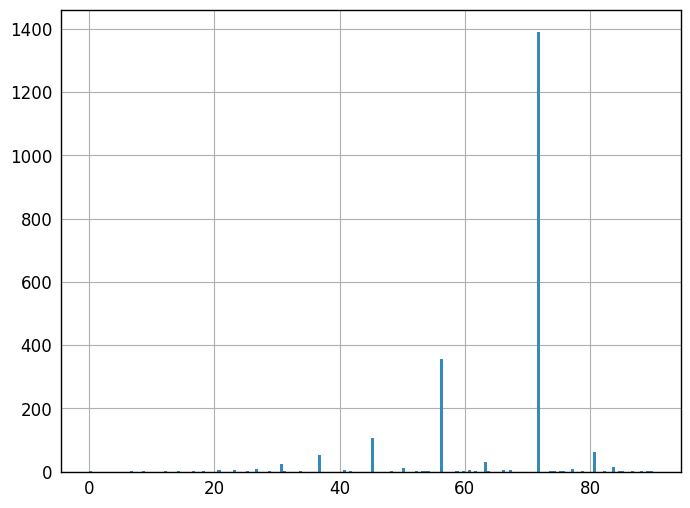

In [45]:
thist = plt.hist(theta,180,range=(0,90))

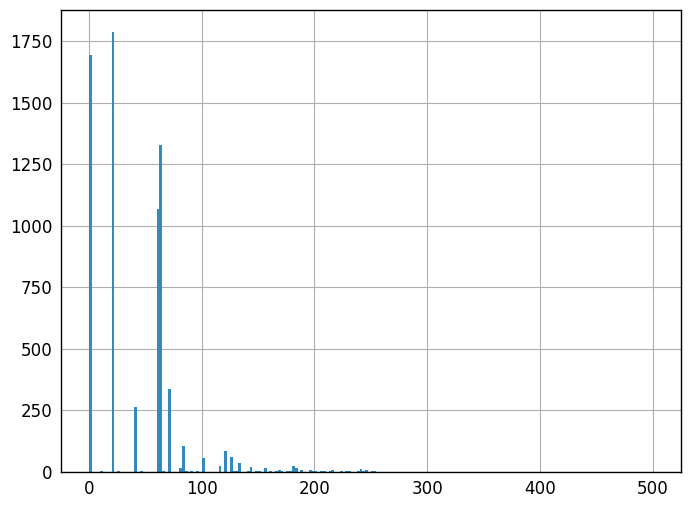

In [46]:
lengths = np.sqrt(lx*lx + ly*ly)

lhist = plt.hist(lengths,200,range=(0,500),log=False)

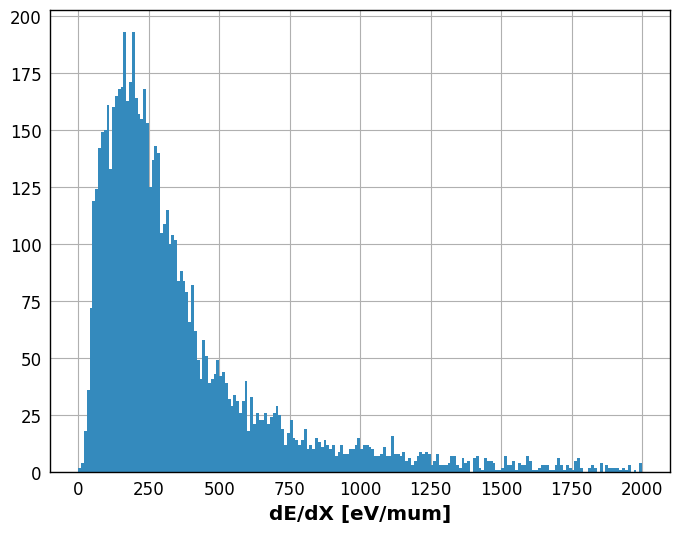

In [47]:
dEdx = Etot/np.sqrt(lengths**2+16**2) # assuming our length measurement is good and we excite the whole detector

dEdx *= 3.6   # energy (eV) per electron/hole pair

thist = plt.hist(dEdx,200,log=False,range=(0,2000))
plt.xlabel("dE/dX [eV/mum]")

Weird thing: In a flare, this actually has the same maximum - although higher counts, especially where this one flattens off.

In [48]:
acqTimes = []

for ii in range(len(out)):
    acqTimes.append(out[ii].acqTime)
    
acqTimes = np.array(acqTimes)

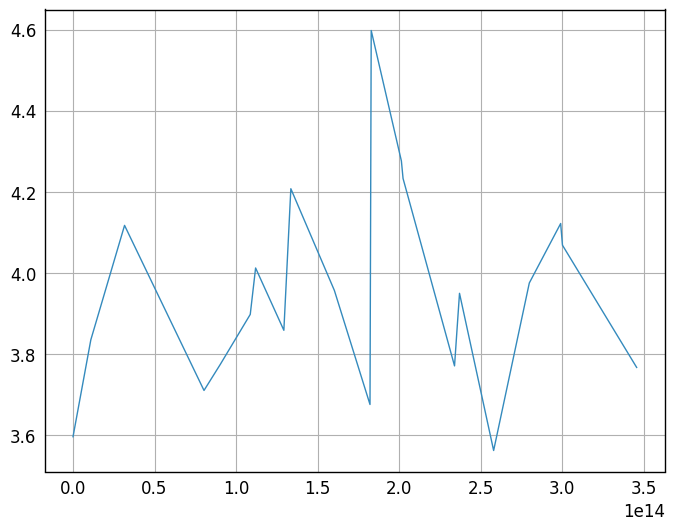

In [49]:
# fluxes
# I should group these by row
flux = [obs.calculate_flux() for obs in out]

plt.plot(acqTimes-acqTimes[0],flux)

In [50]:
# for fun - make a cosmic ray image from a TrackObs

iiobs = 0

obs = out[iiobs]

cosmics = np.zeros((obs.srcAL,obs.srcAC))

for ii in range(len(obs.data)):
    track = np.reshape(obs.data[ii]["TRACK"], (obs.data[ii]["DIM_AL"],obs.data[ii]["DIM_AC"]))
    start_AL = obs.data[ii]["LOC_AL"]
    stop_AL = obs.data[ii]["LOC_AL"] + obs.data[ii]["DIM_AL"]
    start_AC = obs.data[ii]["LOC_AC"]
    stop_AC = obs.data[ii]["LOC_AC"] + obs.data[ii]["DIM_AC"]
    cosmics[start_AL:stop_AL,start_AC:stop_AC] += track

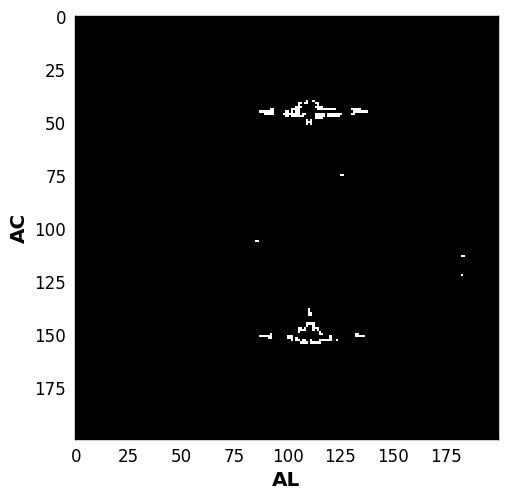

In [51]:
im=np.rot90(cosmics,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(im[600:800,1200:1400], cmap='gray',vmax=20)
plt.gcf().set_size_inches(20.5, 5.5)
#plt.colorbar(orientation="horizontal")
plt.grid(False)

Damn, I'm still seeing stars - first obs of 2017-06-30

Let's hope that adjusting objlim can fix that...

In [79]:
(image,gain,bias,readnoise,fov,row,tstart,tstop) = sm_get_image(sourcefiles[iiobs], "../../datasets/sm_bias/sm_calibdat.fits")

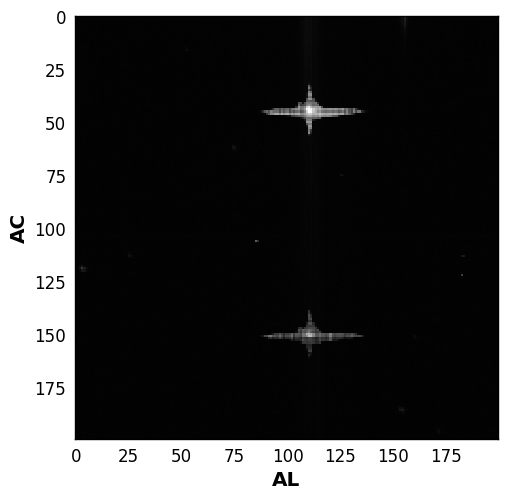

In [83]:
im=np.rot90(image,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(im[600:800,1200:1400], cmap='gray',vmin=1500, norm=LogNorm())
plt.gcf().set_size_inches(20.5, 5.5)
#plt.colorbar(orientation="horizontal")
plt.grid(False)

In [84]:
np.min(im[600:800,1200:1400])

1521